# Project 2

<bk>
    Dieter Brehm and Corinne Wilklow

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
m = UNITS.meter
ft =  UNITS.foot
inch = UNITS.inch


W = UNITS.watt

J = UNITS.joule
btu = UNITS.btu

degC = UNITS.celsius
K = UNITS.kelvin
degF = UNITS.fahrenheit 

hr = UNITS.hour

<Unit('hour')>

In [39]:
R_data = pd.read_csv('Rvalues.csv', header=0, index_col=0, usecols=range(1,2))
print(R_data.head)

<bound method NDFrame.head of Empty DataFrame
Columns: []
Index: [5.0, 3.85, 6.5, 5.0, 4.0, 0.2, 1.25, 4.29, 3.71, 4.13]>


In [4]:
ext_data = pd.read_csv('DataOWall.csv', parse_dates=[0], index_col=0, header=0, skiprows=[1,2])
ext_data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


Convert Index entries to seconds, noticing the spacing between recordings

In [5]:
timestamp_0 = get_first_label(ext_data)
time_deltas = ext_data.index - timestamp_0;

In [6]:
ext_data.index = time_deltas.days * 86400 + time_deltas.seconds
ext_data.head()

,Q_in,Q_out,T_int,T_ext
0,10.994,6.840,16.92,14.68
300,10.952,6.012,16.92,14.69
600,10.882,7.040,16.93,14.66
900,10.798,8.880,16.93,14.59
1200,10.756,10.491,16.94,14.50


Add units to each dataframe (Q_in, Q_out, T_int, T_ext)

In [7]:
ext_data.Q_in.units = W / m**2
ext_data.Q_out.units = W / m**2
ext_data.T_int.units = degC
ext_data.T_ext.units = degC;

In [32]:
def make_system(init, R, d, SA, m, c):
    """Make a system object for the HIV model.
    
    start_temp: starting temp of room 
    gamma: recovery rate in days
    
    returns: System object
    """
    

    t0 = 0
    t_end = 20
    dt = .5

    return System(init=init, t0=t0, t_end=t_end, dt=dt, R=R, d=d, SA=SA, m=m, c=c)

In [38]:
init = State(T_int=60, T_ext=get_first_value(ext_data.T_ext)*9/5+32)
R = 3 #ft^2*deg5/btu/hr/in
d = 4 #inches

#room dimensions
l = 6 #m
w = 6 #m
h = 6 #m

SA = (l * w * 4 + h * l * 2) * 10.7639 #ft^2
V = l * w * h #m^3

rho = 1 #density of air
g = 9.8 #m/s^2, acceleration due to gravity
m = (rho * V * g) * 2.2 #mass of air in room in lb

c = 0.171 #btu/lbm*R

system = make_system(init, R, d, SA, m, c)

,values
init,T_int 60.000 T_ext 58.424 dtype: float64
t0,0
t_end,20
dt,0.5
R,3
d,4
SA,2325
m,4656.96
c,0.171


In [34]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end,system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
    
    return frame

In [35]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    delta_T = T_int - T_ext
    
    dQ= (system.SA * delta_T / (system.R * system.d)) * system.dt
   
    if system.c==0:
        system.c = dQ / delta_T
    
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    #print(dT)
    
    return State(T_int = T_int, T_ext = T_ext)

In [47]:
def sweep_R(R_data):
    '''Sweep a range of values of R
    R =  different R values correlated to specific insulations
    returns SweepSeries'''
    print("r_data", R_data.index.values)
    for R in R_data.index.values:
        systemr = make_system(init, R, d, SA, m, c)
        results = run_simulation(systemr, update_func)
        plot(results.T_int, label=str(R))
        print(results.T_int)
    plt.legend()
    plt.show()

r_data [5.   3.85 6.5  5.   4.   0.2  1.25 4.29 3.71 4.13]
0.0     60.000000
0.5     59.884967
1.0     59.778331
1.5     59.679478
2.0     59.587840
2.5     59.502891
3.0     59.424143
3.5     59.351142
4.0     59.283470
4.5     59.220737
5.0     59.162583
5.5     59.108674
6.0     59.058699
6.5     59.012372
7.0     58.969427
7.5     58.929616
8.0     58.892711
8.5     58.858500
9.0     58.826785
9.5     58.797386
10.0    58.770132
10.5    58.744868
11.0    58.721448
11.5    58.699737
12.0    58.679611
12.5    58.660954
13.0    58.643659
13.5    58.627626
14.0    58.612763
14.5    58.598985
15.0    58.586213
15.5    58.574373
16.0    58.563397
16.5    58.553223
17.0    58.543791
17.5    58.535047
18.0    58.526942
18.5    58.519428
19.0    58.512463
19.5    58.506006
20.0    58.500020
Name: T_int, dtype: float64
0.0     60.000000
0.5     59.850607
1.0     59.715375
1.5     59.592963
2.0     59.482154
2.5     59.381849
3.0     59.291052
3.5     59.208862
4.0     59.134463
4.5     59.06

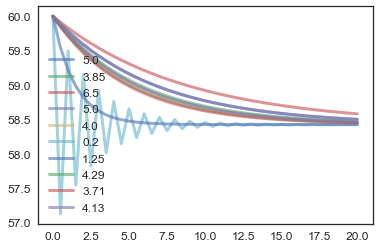

In [48]:
sweep_R(R_data)

In [14]:
update_func(system.init, system.t0, system)

,values
T_int,59.996166
T_ext,58.424000


In [15]:
results = run_simulation(system,update_func)

,T_int,T_ext
0.00,60.000000,58.424
0.01,59.996166,58.424
0.02,59.992340,58.424
0.03,59.988525,58.424
0.04,59.984718,58.424
0.05,59.980921,58.424
0.06,59.977133,58.424
0.07,59.973354,58.424
0.08,59.969585,58.424
0.09,59.965824,58.424


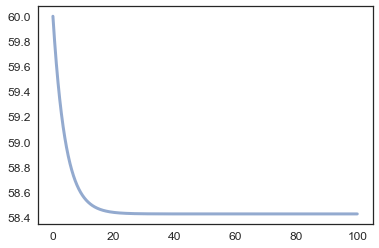

In [16]:
plot(results.T_int)